# Tiered Results Analysis 

This notebook mirrors the multiple results analysis, but loads data from the separate tiered results files. 

In [1]:
%matplotlib inline

import os
import sys 
import json
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

from operator import itemgetter
from itertools import groupby, chain
from collections import defaultdict, Counter

# Modify the Notebook path
sys.path.append(os.path.join(os.getcwd(), ".."))

/usr/local/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
sns.set_style('whitegrid')
sns.set_context('talk')

In [3]:
# Specify a path to a results file 
# If None, will attempt to look one up
FIXTURES = os.path.join("..", "fixtures", "results", "federated")

def get_results_dict(path=FIXTURES):
    for name in os.listdir(path):
        fpath = os.path.join(path, name)
        name, _ = os.path.splitext(name)
        name = name.replace("-"," ")
        yield (name, fpath)

def get_results_data(results):
    """
    Make this look like the multi-results structure. 
    """
    for name, path in results.items():
        with open(path, 'r') as f:
            data = json.load(f) 
            data['topology']['meta']['experiment'] = name 
            yield data 

            
data = list(get_results_data(dict(get_results_dict())))


# Get all the values for a particular key 
def results_values(*key):
    for result in data:
        value = result
        for k in key:
            value = value.get(k, {})
        yield value

rvals = results_values

In [39]:
def create_dataframe():
    table = []
    meta  = list(rvals('topology', 'meta'))
    conf  = list(rvals('settings'))

    for idx, results in enumerate(rvals('results')):
        data = {'eid': "e{:0>2}".format(idx)}
        
        data['experiment'] = meta[idx]['experiment']
        data['variable (ms)'] = meta[idx]['variable']
        
        data['users'] = meta[idx]['experiment'].split()[1][0]
        data['T (ms)'] = conf[idx]['election_timeout'][0]
        data['anti-entropy delay (ms)'] = conf[idx]['anti_entropy_delay']
        data['raft tick (ms)'] = conf[idx]['election_timeout'][0]
        data['replica type'] = meta[idx]['experiment'].split()[0].lower()
        for key, values in results.iteritems():
            
            if key == 'read latency':
                data['read latency (ms)'] = sum(v[3] - v[2] for v in values) / len(values)

            if key == 'write latency':
                data['write latency (ms)'] = sum(v[3] - v[2] for v in values) / len(values)
            
            if key == 'visibility latency':
                data['visibility latency (ms)'] = sum(v[3] - v[2] for v in values) / len(values)
                data['visible writes'] = len(set([v[1] for v in values]))
            if key == 'commit latency':
                data['commit latency (ms)'] = sum(v[3] - v[2] for v in values) / len(values)
                data['committed writes'] = len(set([v[1] for v in values]))
            else:
                data[key] = len(values)
            
            if 'visible writes' not in data:
                data['visible writes'] = 0 
        
        data['ratio fully visible to writes'] = float(data['visible writes']) / float(data['write'])
        data['partial writes'] = data['write'] - data['visible writes'] 
        
        table.append(data)
    
    return pd.DataFrame(table)

df = create_dataframe()
df = df.fillna(0)

/usr/local/lib/python2.7/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


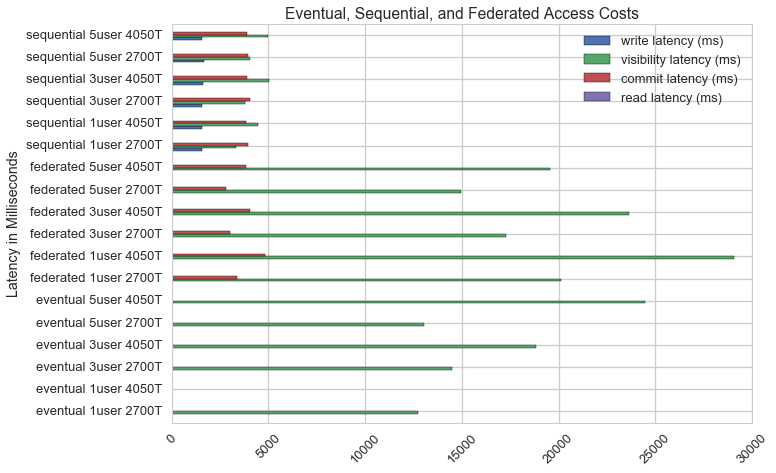

In [6]:
plt.figure(figsize=(14,14))
mpl.rcParams.update({'font.size': 22})

lat = pd.DataFrame(df, columns=['experiment', 'write latency (ms)', 'visibility latency (ms)', 'commit latency (ms)', 'read latency (ms)'])
lat = lat.sort('experiment')
axe = lat.plot(kind='barh', x='experiment', color=sns.color_palette())
axe.set_ylabel('Latency in Milliseconds')
axe.set_xlabel('')
axe.set_title("Eventual, Sequential, and Federated Access Costs")

for tick in axe.get_xticklabels():
    tick.set_rotation(45)

In [58]:
def create_cost_matrix(lat):
    for index, row in lat.iterrows():
        for latency in ('write latency (ms)', 'visibility latency (ms)', 'commit latency (ms)', 'read latency (ms)'):
            yield {
                'replica type': row['replica type'], 
                'users': row['users'],
                'T (ms)': row['T (ms)'], 
                'latency': row[latency],
                'cost': latency,
            }

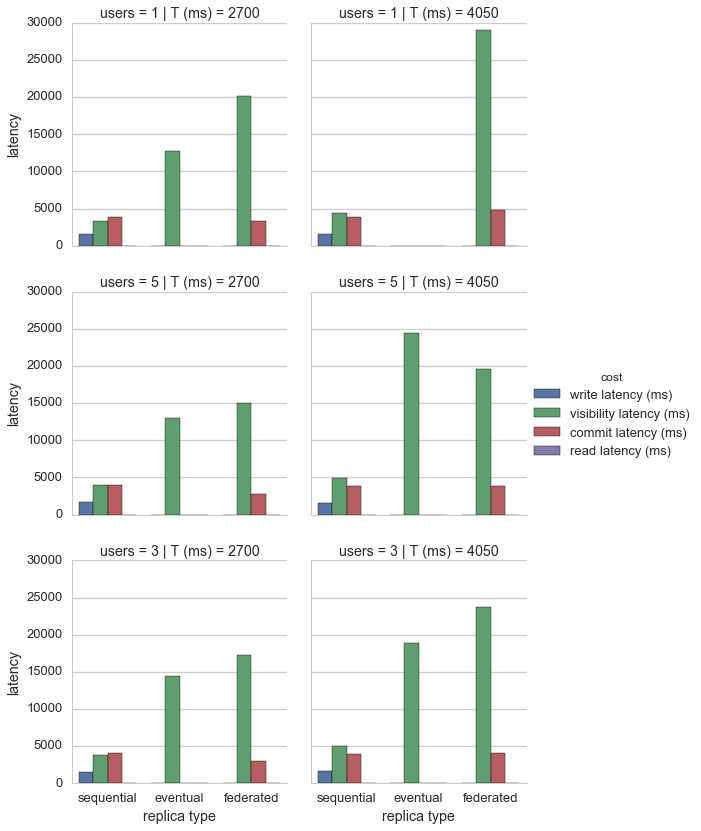

In [60]:
lat = pd.DataFrame(create_cost_matrix(df))
sns.factorplot(data=lat, x='replica type', y='latency', hue='cost', col='T (ms)', row='users', kind='bar')

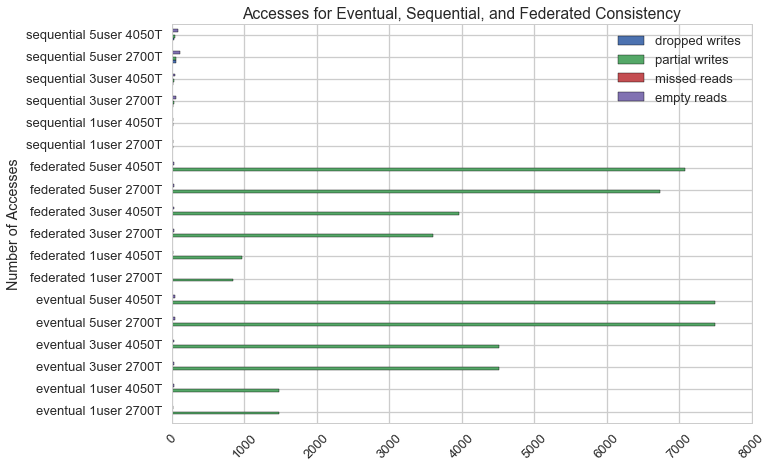

In [7]:
lat = pd.DataFrame(df, columns=['experiment', 'dropped writes', 'partial writes', 'missed reads', 'empty reads'])
lat = lat.sort('experiment')
axe = lat.plot(kind='barh', x='experiment', color=sns.color_palette())
axe.set_ylabel('Number of Accesses')
axe.set_xlabel('')
axe.set_title("Accesses for Eventual, Sequential, and Federated Consistency")

for tick in axe.get_xticklabels():
    tick.set_rotation(45)

In [66]:
def create_access_matrix(lat):
    for index, row in lat.iterrows():
        for access in ('dropped writes', 'partial writes', 'missed reads', 'empty reads'):
            event = row[access] if access in row else 0
            yield {
                'replica type': row['replica type'], 
                'users': row['users'],
                'T (ms)': row['T (ms)'], 
                'access': event,
                'cost': access,
            }

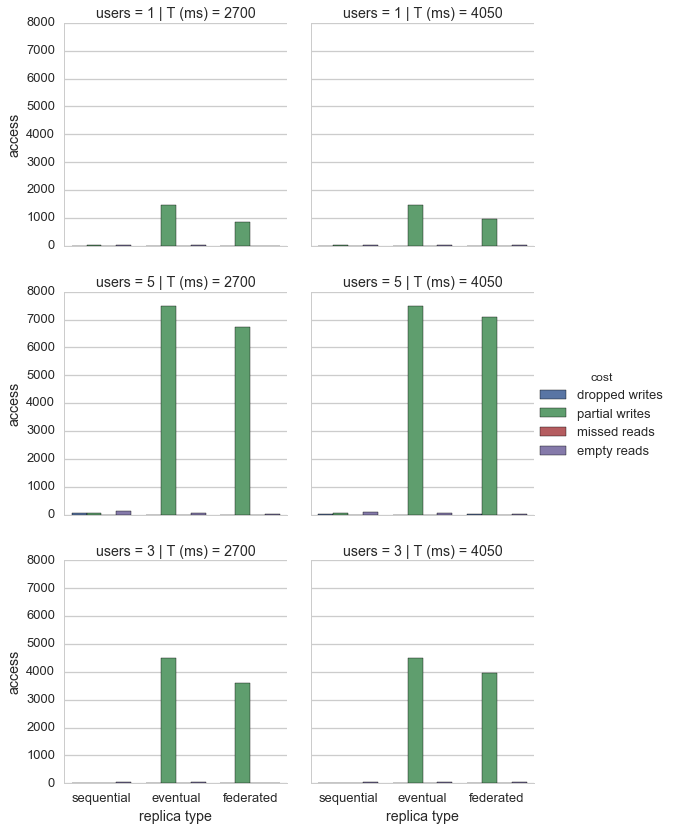

In [67]:
lat = pd.DataFrame(create_access_matrix(df))
sns.factorplot(data=lat, x='replica type', y='access', hue='cost', col='T (ms)', row='users', kind='bar')

In [8]:
# Create Message Traffic Data Frame 
columns = ['replica', 'timestamp', 'type', 'latency']

def messages():
    meta  = list(rvals('topology', 'meta'))
    for idx, result in enumerate(rvals('results')):
        for key in ('sent', 'recv'):
            for message in result[key]:
                msg = dict(zip(columns, message))
                msg['experiment'] = meta[idx]['experiment']
                msg['recv'] = 1 if key == 'recv' else 0
                msg['sent'] = 1 if key == 'sent' else 0
                yield msg

def count(nums):
    return sum(nums)
            
msgs = pd.DataFrame(messages())

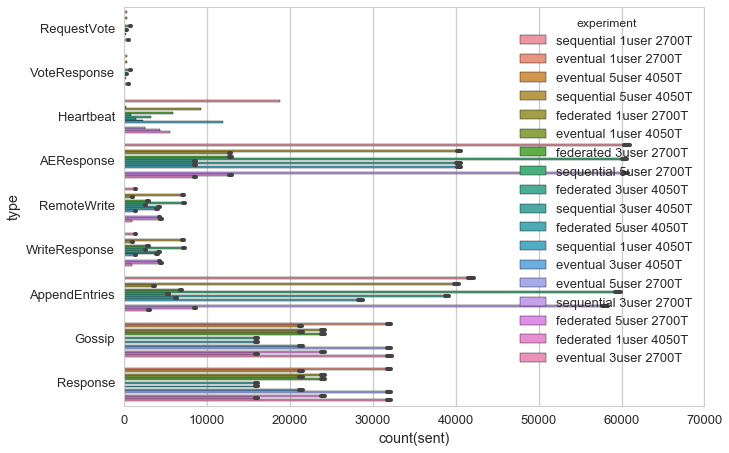

In [9]:
sns.barplot(y='type', x='sent', hue='experiment', data=msgs, estimator=count)